<a href="https://colab.research.google.com/github/ua-datalab/Workshops/blob/main/A_SQL_Masterclass/A_SQL_Masterclass_Part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To run SQL in colab we need some libraries and a database management system.(DBMS) We used duckdb as a DBMS

In [ ]:
%%capture

!pip install notebook
!pip install jupysql
!pip install duckdb-engine

import duckdb
import pandas as pd

%load_ext sql
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False
%sql duckdb:///:default:


# Creating and populating some tables for SQL practice

In [ ]:
%%sql
Drop table if  exists users;
Drop table if exists orders;
CREATE TABLE if not exists users
                (id INTEGER ,
                 name TEXT,
                 age INTEGER,
                 city TEXT);
CREATE TABLE if not exists  orders
                (id INTEGER PRIMARY KEY,
                 user_id INTEGER,
                 product TEXT,
                 amount REAL,
                 comment TEXT
                 );
INSERT INTO users (id,name, age, city) VALUES(1,'John Doe', 30, 'New York'),
                    (2,'Jane Doe', 25, 'Los Angeles'),
                    (3,'Jim Brown', 35, 'Chicago'),
                    (4,'Jim Doe', 35, 'Tucson');
INSERT INTO orders (id,user_id, product, amount,comment) VALUES
(1,1, 'Product A', 100.0, '{"location" : "Tucson"}'),
                    (2,2, 'Product B', 200.0,'{"location" : "Phoenix","categories" : ["fashion","clothes"]}'),
                    (3,1, 'Product C', 150.0,'{"location" : "Tucson","categories" : ["electronics","computers"]}'),
                    (4,3, 'Product D', 300.0,'{"location" : "Phoenix","categories" : ["grocery"]}')

,Success


## Subqueries

A subquery is a query that appears inside another query statement.


In [ ]:
%%sql

 SELECT name,o.amount
    FROM orders o
    join users u
    on u.id = o.user_id

,name,amount
0,John Doe,100.0
1,Jane Doe,200.0
2,John Doe,150.0
3,Jim Brown,300.0


In [ ]:
%%sql

select user_id, sum(amount)as total from orders group by user_id

,user_id,total
0,1,250.0
1,2,200.0
2,3,300.0


## Correlated Subquery: Each subquery is executed once for every row of the outer query.

In [ ]:
%%sql

  Select o.*, round((o.amount/total)*100) as percetage from orders o
   join (select user_id, sum(amount)as total from orders group by user_id) uo
   on uo.user_id = o.user_id

,id,user_id,product,amount,comment,percetage
0,1,1,Product A,100.0,"{""location"" : ""Tucson""}",40.0
1,2,2,Product B,200.0,"{""location"" : ""Phoenix"",""categories"" : [""fashi...",100.0
2,3,1,Product C,150.0,"{""location"" : ""Tucson"",""categories"" : [""electr...",60.0
3,4,3,Product D,300.0,"{""location"" : ""Phoenix"",""categories"" : [""groce...",100.0


In [ ]:
%%sql

SELECT  avg(amount) as avg_amount FROM orders

,avg_amount
0,187.5


In [ ]:
%%sql

 SELECT name,o.amount
    FROM orders o
    join users u
    on u.id = o.user_id
    where o.amount > (SELECT  avg(amount) as avg_amount FROM orders )

,name,amount
0,Jane Doe,200.0
1,Jim Brown,300.0


# More Operators

### OR

In [ ]:
%%sql

select * from users where city = 'New York' or city = 'Los Angeles'

,id,name,age,city
0,1,John Doe,30,New York
1,2,Jane Doe,25,Los Angeles


### AND

In [ ]:
%%sql

select * from users where city = 'New York'  and name= 'John Doe'

,id,name,age,city
0,1,John Doe,30,New York


### IN

In [ ]:
%%sql

select * from users where city in ('New York','Los Angeles')

,id,name,age,city
0,1,John Doe,30,New York
1,2,Jane Doe,25,Los Angeles


In [ ]:
%%sql

select * from users where id not in (select user_id from orders)

,id,name,age,city
0,4,Jim Doe,35,Tucson


### EXISTS

In [ ]:
%%sql

select * from users u where not exists (select user_id from orders o where u.id = o.user_id)

,id,name,age,city
0,4,Jim Doe,35,Tucson


In [ ]:
%%sql

select * from users u where  exists (select user_id from orders o where u.id = o.user_id)

,id,name,age,city
0,1,John Doe,30,New York
1,2,Jane Doe,25,Los Angeles
2,3,Jim Brown,35,Chicago


### Limit

In [ ]:
%%sql

Select * from users limit 2

,id,name,age,city
0,1,John Doe,30,New York
1,2,Jane Doe,25,Los Angeles


In [ ]:
%%sql

Select * from users order by id desc limit 2

,id,name,age,city
0,4,Jim Doe,35,Tucson
1,3,Jim Brown,35,Chicago


### Limit with offset
Useful for nth highest

Select * from Table order by field desc limit 1 offset n-1

In [ ]:
%%sql

Select * from users order by id desc limit 2 offset 0

,id,name,age,city
0,4,Jim Doe,35,Tucson
1,3,Jim Brown,35,Chicago


In [ ]:
%%sql

Select * from users order by id desc limit 2 offset 1

,id,name,age,city
0,3,Jim Brown,35,Chicago
1,2,Jane Doe,25,Los Angeles


In [ ]:
%%sql

Select * from users order by id desc limit 2 offset 2

,id,name,age,city
0,2,Jane Doe,25,Los Angeles
1,1,John Doe,30,New York


In [ ]:
%%sql

Select * from users order by id desc limit 1 offset 1

,id,name,age,city
0,3,Jim Brown,35,Chicago


## CTEs

A Common Table Expression (CTE) is the result set of a query which exists temporarily and for use only within the context of a larger query.

In [ ]:
%%sql

with user_details as (

select
id, name, age, case when city = 'New York' then 'NY' else 'Non-NY' end as city

 from
users

)

Select * from user_details

,id,name,age,city
0,1,John Doe,30,NY
1,2,Jane Doe,25,Non-NY
2,3,Jim Brown,35,Non-NY
3,4,Jim Doe,35,Non-NY


## Set operations


In [ ]:
%%sql

Select id from users


,id
0,1
1,2
2,3
3,4


- **UNION ALL**: Combine all results from two query blocks into a single
result, without omitting any duplicates.

In [ ]:
%%sql

Select id from users
union all
Select id from users

,id
0,1
1,2
2,3
3,4
4,1
5,2
6,3
7,4


- **UNION**: Combine all results from two query blocks into a single result, omitting any duplicates.

In [ ]:
%%sql

Select id from users
union
Select id from users


,id
0,1
1,2
2,3
3,4


- **INTERSECT**: Combine only those rows which the results of two query blocks have in common, omitting any duplicates.

In [ ]:
%%sql


Select id from users where id  <=2
intersect
Select id from users


,id
0,1
1,2



- **EXCEPT**: For two query blocks A and B, return all results from A which are not also present in B, omitting any duplicates.

In [ ]:
%%sql
Select id from users
EXCEPT
Select id from users where id  <=2

,id
0,3
1,4


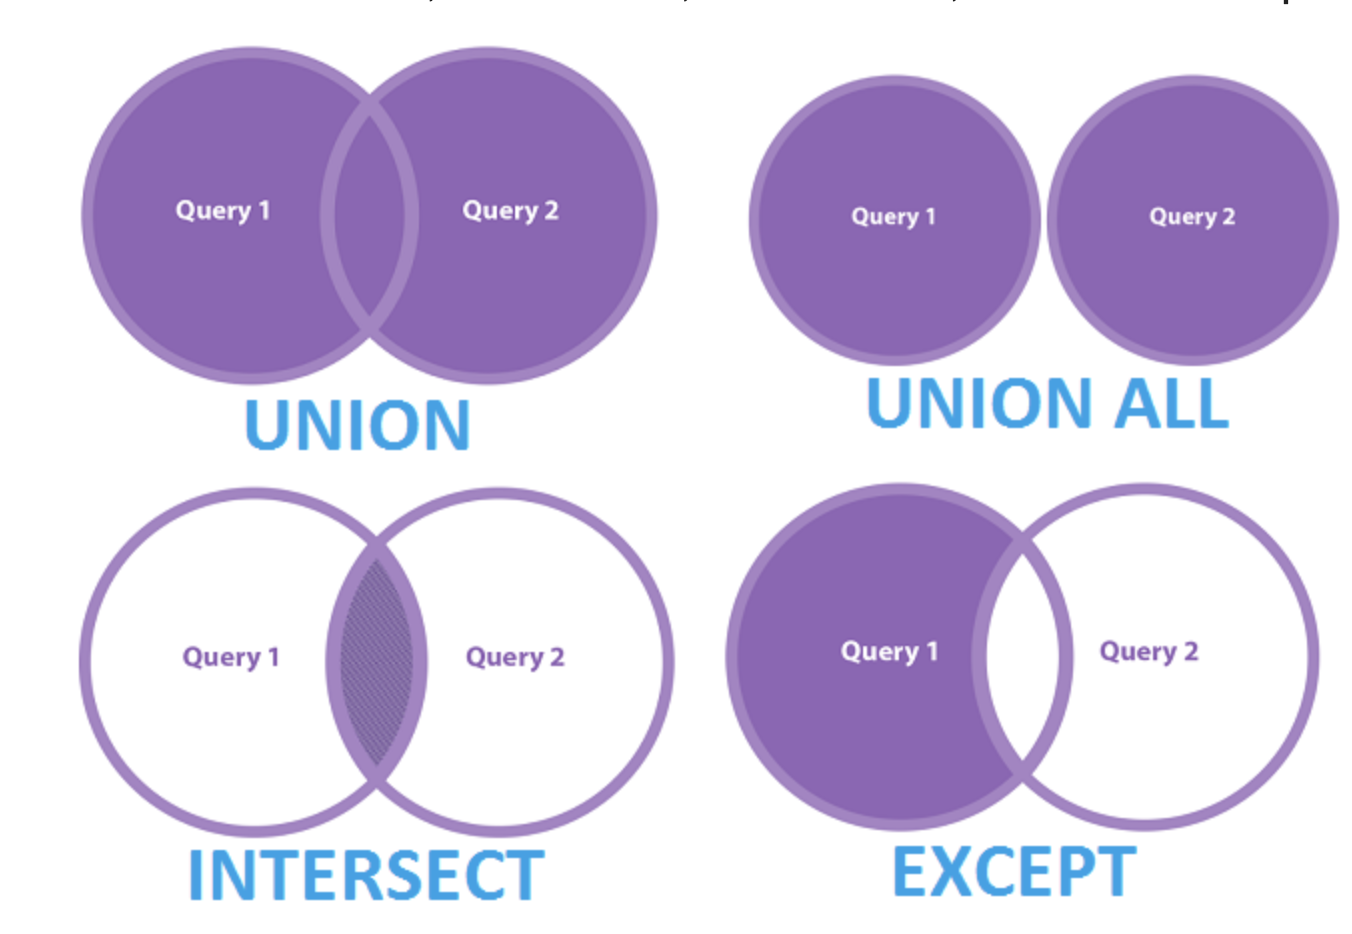

##  Unstructured Data

Like Json (Dictionary) and Arrays (List)

In [ ]:
%%sql
SELECT
id,comment
 from orders

,id,comment
0,1,"{""location"" : ""Tucson""}"
1,2,"{""location"" : ""Phoenix"",""categories"" : [""fashi..."
2,3,"{""location"" : ""Tucson"",""categories"" : [""electr..."
3,4,"{""location"" : ""Phoenix"",""categories"" : [""groce..."


In [ ]:
%%sql
SELECT
id,user_id, product, amount, json_extract_string(comment,'$.location') as location
 from orders

,id,user_id,product,amount,location
0,1,1,Product A,100.0,Tucson
1,2,2,Product B,200.0,Phoenix
2,3,1,Product C,150.0,Tucson
3,4,3,Product D,300.0,Phoenix


In [ ]:
%%sql

SELECT
id,user_id, product, amount,
json_extract(comment,'$.categories') as categories ,
unnest(json_extract(comment,'$.categories'):: VARCHAR[]) as catergory
 from orders

,id,user_id,product,amount,categories,catergory
0,2,2,Product B,200.0,"[""fashion"",""clothes""]",fashion
1,2,2,Product B,200.0,"[""fashion"",""clothes""]",clothes
2,3,1,Product C,150.0,"[""electronics"",""computers""]",electronics
3,3,1,Product C,150.0,"[""electronics"",""computers""]",computers
4,4,3,Product D,300.0,"[""grocery""]",grocery


## Temporary tables
A temporary table is visible only within the current session, and is dropped automatically when the session is closed

In [ ]:
%%sql
create temp table if not exists users_temp
                (id INTEGER ,
                 name TEXT,
                 age INTEGER,
                 city TEXT)

,Success


In [ ]:
%%sql
select * from users_temp

,id,name,age,city


## User Defined functions (UDF)

Different DBMS have different ways of creating a udf function.

In [ ]:
import duckdb
from duckdb.typing import VARCHAR

def get_city_type(city):
  data = {'New York': 'NY'}
  return data.get(city,'Non-NY')
duckdb
duckdb.create_function('get_city_type', get_city_type, [VARCHAR], VARCHAR)

In [ ]:
%%sql

select *, get_city_type(city) as city_type from users

,id,name,age,city,city_type
0,1,John Doe,30,New York,NY
1,2,Jane Doe,25,Los Angeles,Non-NY
2,3,Jim Brown,35,Chicago,Non-NY
3,4,Jim Doe,35,Tucson,Non-NY


## Recursive CTES


A Recursive Common Table Expression (CTE) in SQL is a special type of CTE that allows for recursive execution of a query.

The structure of a recursive CTE includes two parts:

- Anchor Member: This is the non-recursive part of the CTE. It provides the initial set of rows in the result set.
- Recursive Member: This is the part of the CTE that refers to the CTE itself, using a UNION ALL statement. It defines how to join the current set of rows with the next set of rows.

The recursive CTE continues to execute the recursive member until it reaches a point where no more rows are added to the result set. This is determined by the condition specified in the recursive member.

In [ ]:
%%sql

with RECURSIVE cons_seq as (
    select 1 as id

    union all

    select id+1 as id from cons_seq where id <5


)

select * from cons_seq

,id
0,1
1,2
2,3
3,4
4,5


# Window Functions
A window function makes a calculation across multiple rows that are related to the current row

*   MIN
*   MAX
*   SUM
*   AVG
*   LEAD
*   LAG
*   RANK
*   DENSE_RANK
*   ROW_NUMBER


- **Over** keyword is used to indicate that you are about to define a window function.
- The window function will be applied to each **partition** separately

In [ ]:
%%sql

select * ,
sum(amount) over(order by id) as runnning_total,
lag(amount,1) over(order by id) as prev_order_amount,
lag(amount,1) over(partition by user_id order by id) as prev_user_order_amount,
lead(amount,1) over(order by id) as next_order_amount,
lead(amount,1) over(partition by user_id order by id) as next_user_order_amount

 FROM orders o
 order by id

,id,user_id,product,amount,comment,runnning_total,prev_order_amount,prev_user_order_amount,next_order_amount,next_user_order_amount
0,1,1,Product A,100.0,"{""location"" : ""Tucson""}",100.0,NaN,NaN,200.0,150.0
1,2,2,Product B,200.0,"{""location"" : ""Phoenix"",""categories"" : [""fashi...",300.0,100.0,NaN,150.0,NaN
2,3,1,Product C,150.0,"{""location"" : ""Tucson"",""categories"" : [""electr...",450.0,200.0,100.0,300.0,NaN
3,4,3,Product D,300.0,"{""location"" : ""Phoenix"",""categories"" : [""groce...",750.0,150.0,NaN,NaN,NaN


In [ ]:
%%sql
with data as (select id, user_id from orders union all select id , user_id from orders  union all select id , user_id from orders )

Select
user_id,
id,
row_number() over (partition by user_id order by id) as row_no,
dense_rank() over (partition by user_id order by id) as dr,
rank() over (partition by user_id order by id) as rnk

 FROM data o
 where user_id in (1,2)
 order by user_id,id

,user_id,id,row_no,dr,rnk
0,1,1,1,1,1
1,1,1,2,1,1
2,1,1,3,1,1
3,1,3,4,2,4
4,1,3,5,2,4
5,1,3,6,2,4
6,2,2,1,1,1
7,2,2,2,1,1
8,2,2,3,1,1


# Practice

In [ ]:
%%sql
Drop table if  exists new_users;
CREATE TABLE if not exists new_users
                (p_id INTEGER ,
                 p_name TEXT,
                 p_age INTEGER,
                 p_city TEXT,
                 state text
                 );
INSERT INTO new_users (p_id,p_name, p_age, p_city,state) VALUES(1,'John Doe', 30, 'New York',Null),
                    (6,'Jane Doe', 25, 'Los Angeles',Null),
                    (7,'Jim Brown', 35, 'Chicago',Null),
                    (8,'Jim Doe', 35, 'Tucson','Arizona');

,Success


1. Write a query to combine the data from two tables users and new_users.

Expected_soln:
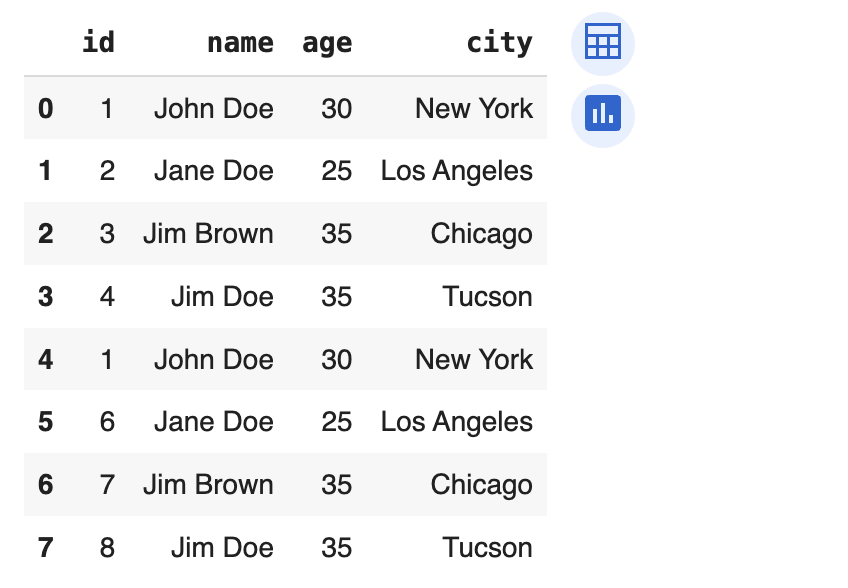

2. Write a query to combine the data from two tables users and new_users. There should not be any duplicates and sort the final results by id

Expected Soln:
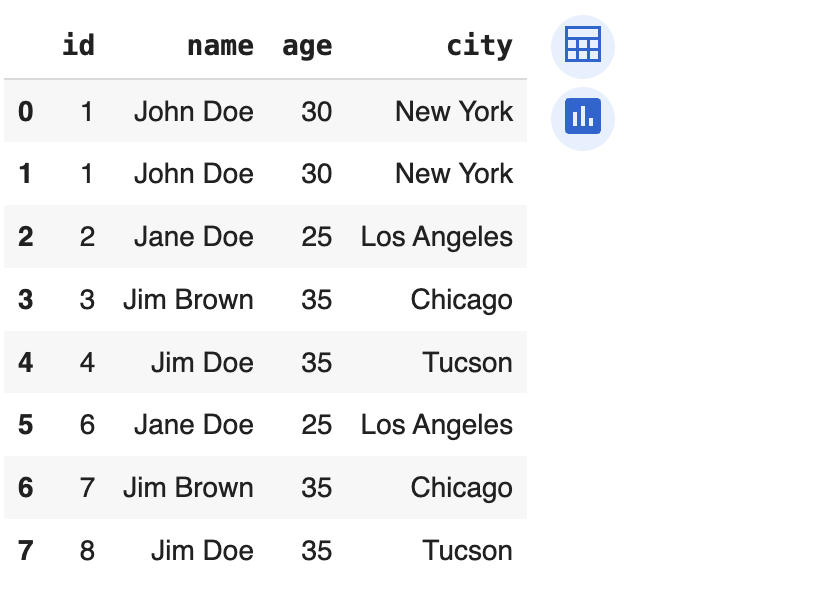

3. Write a query to get the location of the order which has 2nd lowest amount from orders table. Answer should be without quotes

Expected Soln: 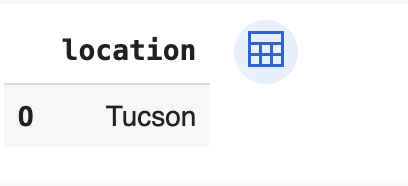

4. Calculate total running average of amount across all orders and per user from orders table. Sort the results by id

Expected Soln:
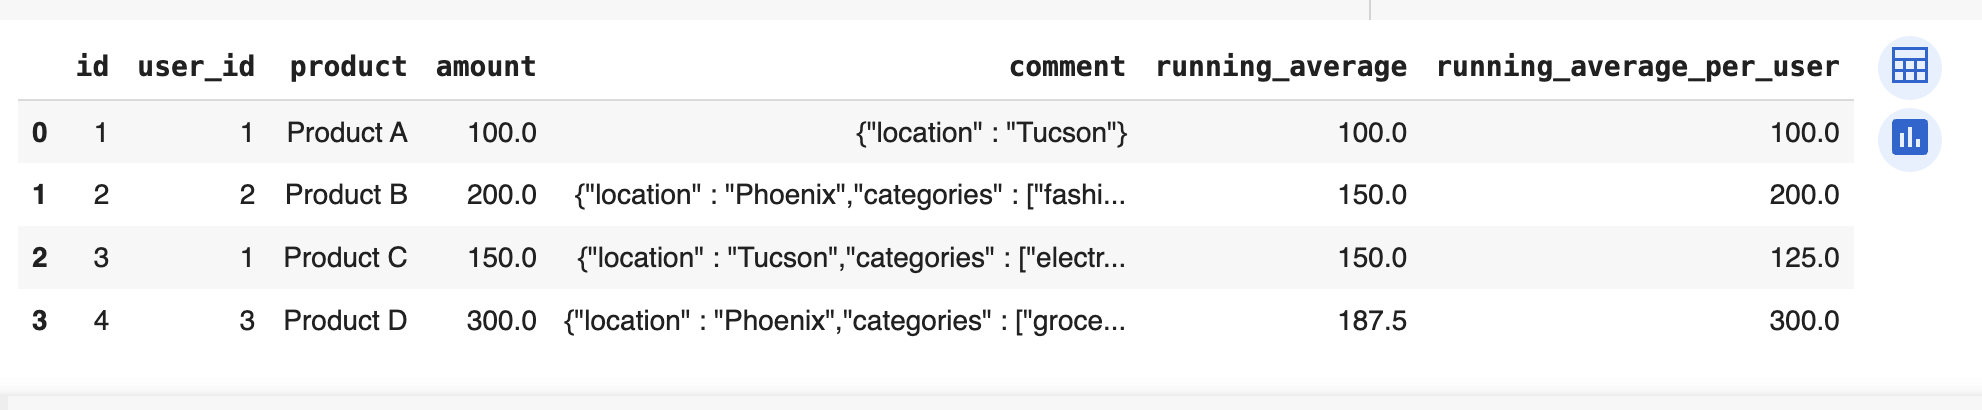